In [102]:
import json
import os
import pickle
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, StackingClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    log_loss,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

plt.style.use("seaborn-v0_8")
sns.set_context("talk")

In [103]:
cfg = {
    "data_path": "data/unified_exoplanets_final_imputed.csv",
    "seed": 42,
    "top_k": 8,
    "corr_thr": 0.95,
    "test_split": 0.2,
    "cv": 5,
    "scoring": "roc_auc",
}
drop_pats = ("disposition", "label", "planet", "mission", "_imputed", "host_star_id")

label_map = {
    "CONFIRMED": 1,
    "FALSE POSITIVE": 0,
    "REFUTED": 0,
    "FA": 0,
}


def load_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.dropna(axis=1, how="any")
    return df


def build_supervised(df: pd.DataFrame) -> pd.DataFrame:
    lbl = df["disposition"].map(label_map)
    mask = lbl.notna()
    sup_df = df.loc[mask].copy()
    sup_df["label"] = lbl.loc[mask].astype(int)
    return sup_df


def pick_features(df: pd.DataFrame) -> list[str]:
    num_cols = df.select_dtypes(include=["number"]).columns
    return [c for c in num_cols if not any(pat in c for pat in drop_pats)]


df = load_data(cfg["data_path"])
sup_df = build_supervised(df)
feat_cols = pick_features(sup_df)

X = sup_df[feat_cols].fillna(sup_df[feat_cols].median())
y = sup_df["label"].astype(int)

Xtr, Xte, ytr, yte = train_test_split(
    X,
    y,
    test_size=cfg["test_split"],
    random_state=cfg["seed"],
    stratify=y,
)

print(f"Samples: {len(sup_df)} | Features kept: {len(feat_cols)}")
print(f"Train/Test split: {Xtr.shape} / {Xte.shape}")
print(f"Positive ratio (train/test): {ytr.mean():.3f} / {yte.mean():.3f}")

Samples: 8367 | Features kept: 17
Train/Test split: (6693, 17) / (1674, 17)
Positive ratio (train/test): 0.328 / 0.328


Correlation filter dropped: 1 cols
Selected top-8 features: ['transit_epoch_bjd', 'transit_depth_ppm', 'equilibrium_temp_k', 'impact_parameter', 'stellar_teff_k', 'stellar_mass_msun', 'stellar_logg', 'radius_ratio_est']
Balanced samples: 8996 (pos ratio: 0.500)


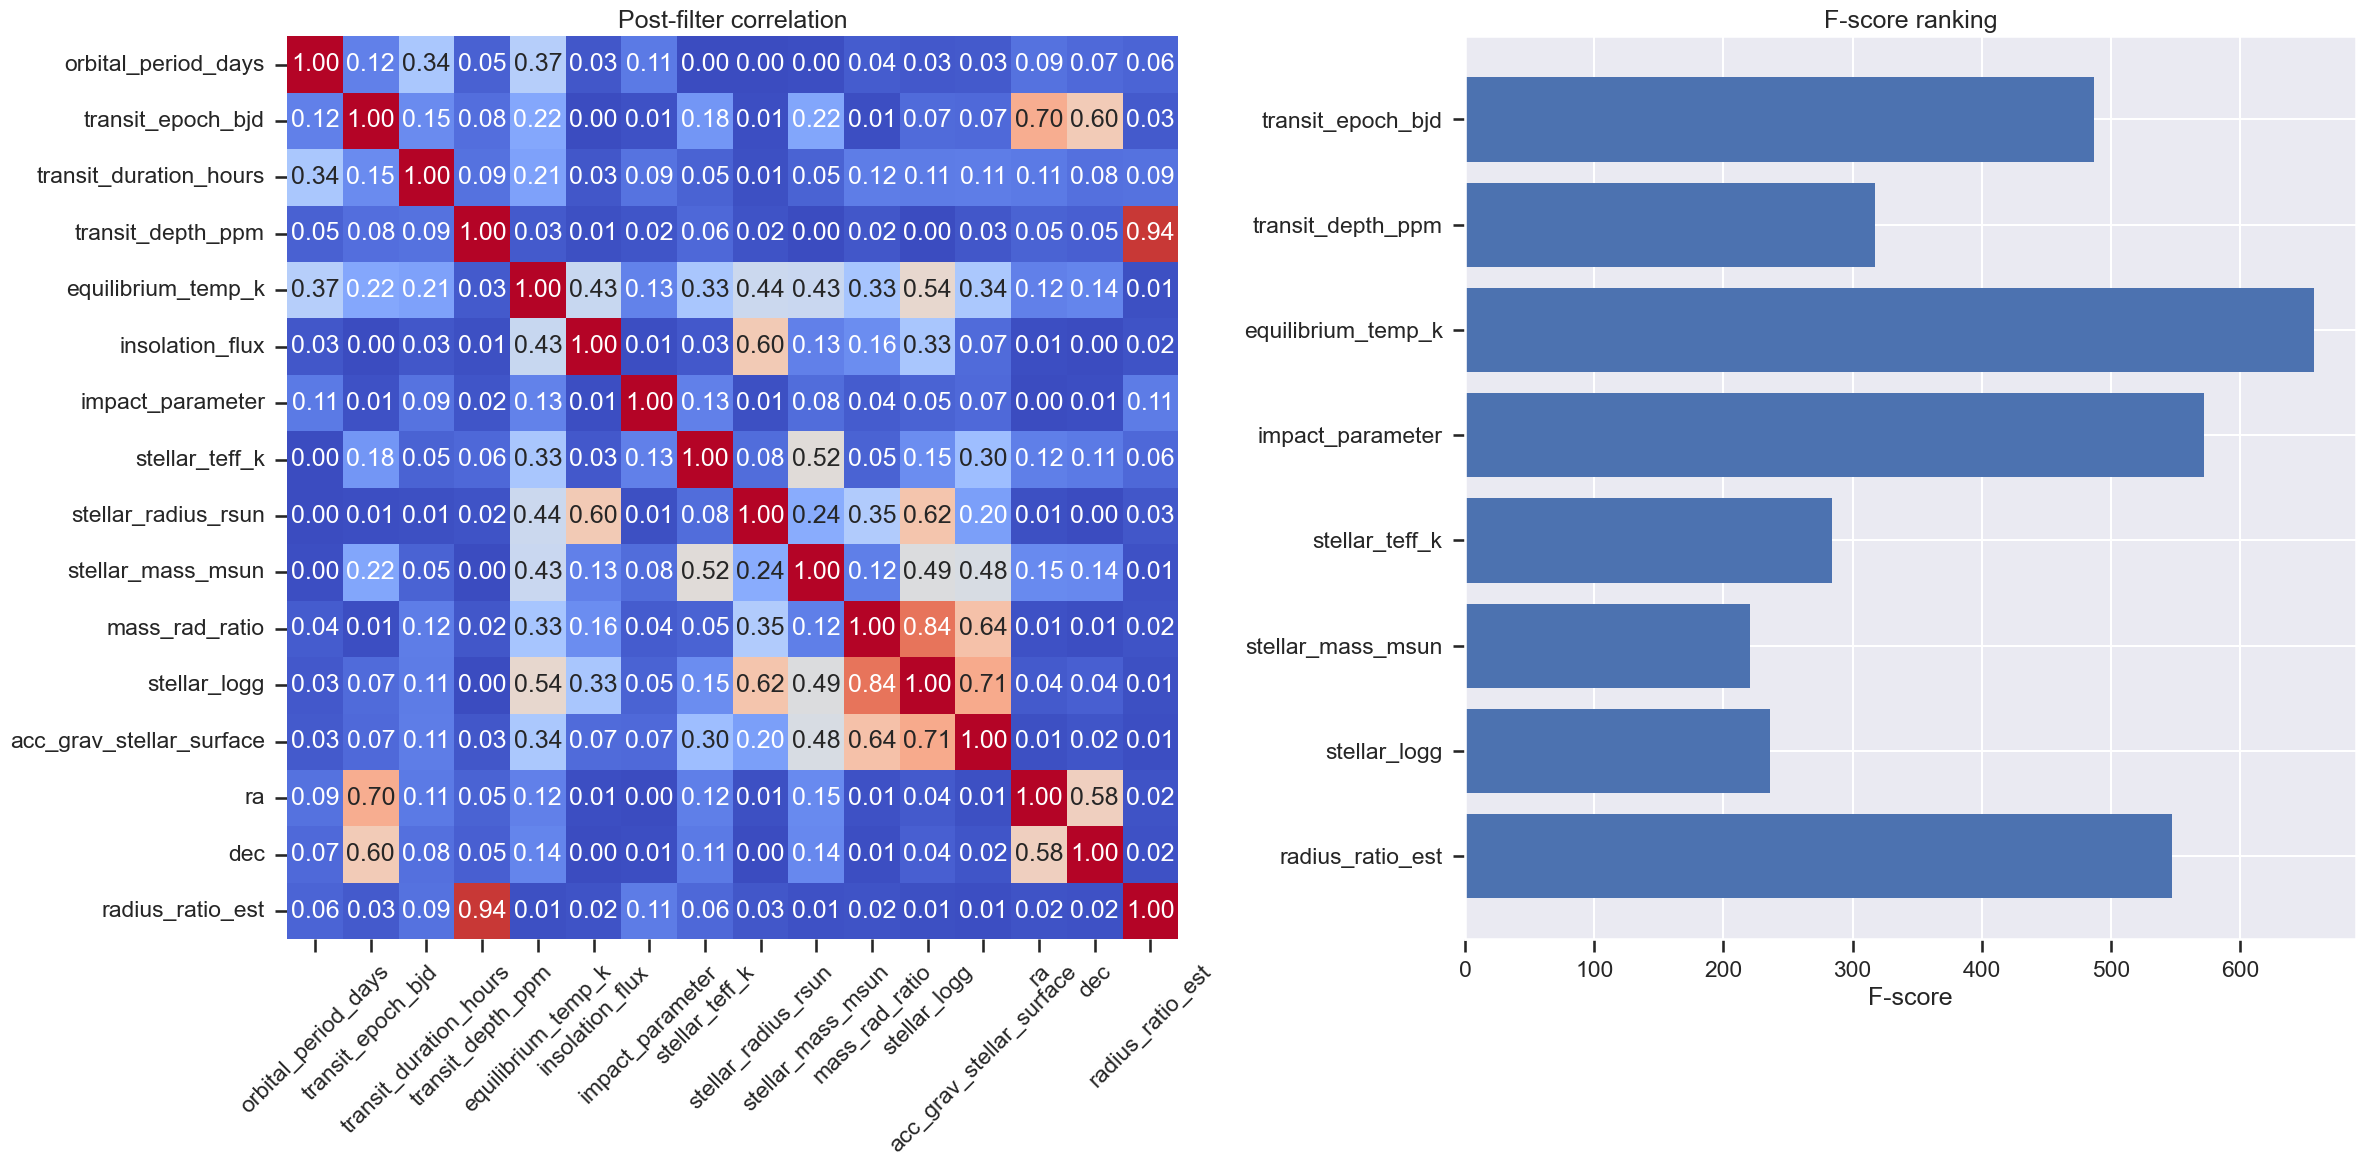

In [104]:
def corr_filter(df: pd.DataFrame, cols: list[str], thr: float) -> tuple[list[str], list[str], pd.DataFrame]:
    corr = df[cols].corr().abs()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    drop = [c for c in upper.columns if any(upper[c] > thr)]
    keep = [c for c in cols if c not in drop]
    return keep, drop, corr.loc[keep, keep]


flt_cols, drop_cols, corr_mat = corr_filter(Xtr, feat_cols, cfg["corr_thr"])
selector = SelectKBest(score_func=f_classif, k=min(cfg["top_k"], len(flt_cols)))
selector.fit(Xtr[flt_cols], ytr)
sel_idx = selector.get_support(indices=True)
sel_feats = [flt_cols[i] for i in sel_idx]
sel_scores = selector.scores_[sel_idx]

scaler = StandardScaler()
Xtr_sel = scaler.fit_transform(Xtr[sel_feats])
Xte_sel = scaler.transform(Xte[sel_feats])

ros = RandomOverSampler(random_state=cfg["seed"])
Xtr_bal, ytr_bal = ros.fit_resample(Xtr_sel, ytr)

print(f"Correlation filter dropped: {len(drop_cols)} cols")
print(f"Selected top-{len(sel_feats)} features: {sel_feats}")
print(f"Balanced samples: {len(ytr_bal)} (pos ratio: {ytr_bal.mean():.3f})")

fig, ax = plt.subplots(1, 2, figsize=(24, 12))
sns.heatmap(corr_mat, ax=ax[0], cmap="coolwarm", annot=True, fmt=".2f", cbar=False)
ax[0].set_title("Post-filter correlation")
ax[0].tick_params(axis="x", rotation=45)

ax[1].barh(sel_feats, sel_scores)
ax[1].invert_yaxis()
ax[1].set_title("F-score ranking")
ax[1].set_xlabel("F-score")
plt.tight_layout()
plt.show()

Tuned base learners:
  RF: gap 0.0145, val 0.9660 with {'max_depth': 10, 'max_features': 0.7, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 120}
  GB: gap 0.0174, val 0.9663 with {'learning_rate': 0.06, 'max_depth': 5, 'min_samples_split': 8, 'n_estimators': 120, 'subsample': 0.8}
  SVM: gap 0.0017, val 0.9432 with {'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}
  LR: gap 0.0006, val 0.8364 with {'C': 0.5, 'penalty': 'l1', 'solver': 'liblinear'}
Average absolute gap: 0.0085

Train metrics:
{'accuracy': 0.9308232481697296, 'f1': 0.9016358614828978, 'precision': 0.8447452229299363, 'recall': 0.966742596810934, 'roc_auc': 0.9811758402367644, 'avg_precision': 0.9556010570536038, 'log_loss': 0.17646744464136907}

Test metrics:
{'accuracy': 0.8763440860215054, 'f1': 0.8226221079691517, 'precision': 0.7766990291262136, 'recall': 0.8743169398907104, 'roc_auc': 0.9541793159279498, 'avg_precision': 0.9083582410687961, 'log_loss': 0.2906548228166533}

Confusion matrix (test):
[[987

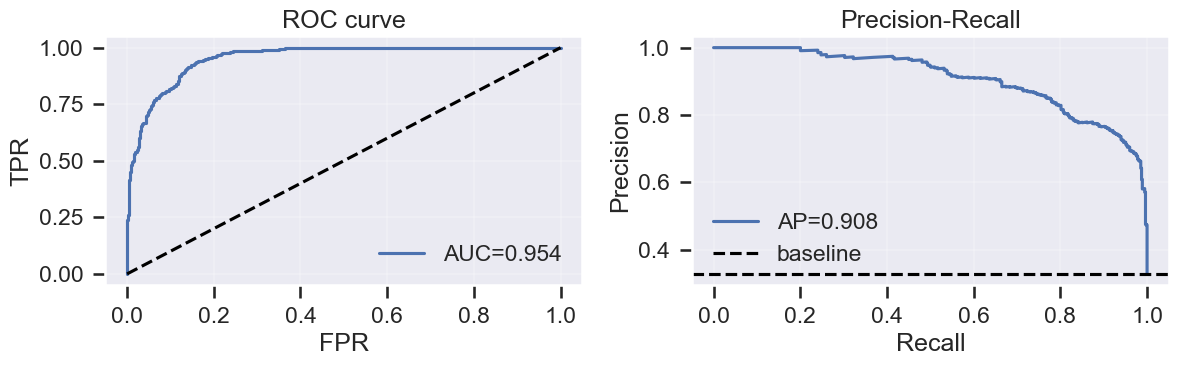


Classification report (test):
                precision    recall  f1-score   support

Not confirmed       0.93      0.88      0.91      1125
    Confirmed       0.78      0.87      0.82       549

     accuracy                           0.88      1674
    macro avg       0.86      0.88      0.86      1674
 weighted avg       0.88      0.88      0.88      1674



In [105]:
grids = {
    "rf": {
        "n_estimators": [80, 120],
        "max_depth": [6, 10],
        "min_samples_split": [4, 8],
        "min_samples_leaf": [2, 4],
        "max_features": ["sqrt", 0.7],
    },
    "gb": {
        "n_estimators": [80, 120],
        "learning_rate": [0.03, 0.06],
        "max_depth": [3, 5],
        "subsample": [0.8, 0.9],
        "min_samples_split": [8, 12],
    },
    "svm": {
        "C": [0.05, 0.1, 0.5],
        "gamma": ["scale"],
        "kernel": ["rbf"],
    },
    "lr": {
        "C": [0.05, 0.1, 0.5],
        "penalty": ["l1", "l2"],
        "solver": ["liblinear"],
    },
}

mdl_map = {
    "rf": RandomForestClassifier(random_state=cfg["seed"], n_jobs=-1),
    "gb": GradientBoostingClassifier(random_state=cfg["seed"], validation_fraction=0.2, n_iter_no_change=10),
    "svm": SVC(probability=True, random_state=cfg["seed"], cache_size=500),
    "lr": LogisticRegression(random_state=cfg["seed"], max_iter=2000),
}


from sklearn.base import BaseEstimator

best_map: dict[str, BaseEstimator] = {}
stat_map: dict[str, dict] = {}


def tune(name: str, mdl, grid: dict) -> None:
    gs = GridSearchCV(
        mdl,
        grid,
        cv=cfg["cv"],
        scoring=cfg["scoring"],
        n_jobs=-1,
        return_train_score=True,
    )
    gs.fit(Xtr_bal, ytr_bal)
    idx = gs.best_index_
    res = gs.cv_results_
    stat_map[name] = {
        "params": gs.best_params_,
        "train": float(res["mean_train_score"][idx]),
        "val": float(res["mean_test_score"][idx]),
        "gap": float(res["mean_train_score"][idx] - res["mean_test_score"][idx]),
    }
    best_map[name] = gs.best_estimator_


for name, mdl in mdl_map.items():
    tune(name, mdl, grids[name])

avg_gap = float(np.mean([abs(stat["gap"]) for stat in stat_map.values()]))

print("Tuned base learners:")
for name, stat in stat_map.items():
    print(f"  {name.upper()}: gap {stat['gap']:.4f}, val {stat['val']:.4f} with {stat['params']}")
print(f"Average absolute gap: {avg_gap:.4f}")

meta = LogisticRegression(random_state=cfg["seed"], C=0.25, penalty="l2", max_iter=2000)
stk = StackingClassifier(
    estimators=[(name, est) for name, est in best_map.items()],
    final_estimator=meta,
    cv=cfg["cv"],
    stack_method="predict_proba",
    n_jobs=-1,
    passthrough=False,
)
stk.fit(Xtr_bal, ytr_bal)

# ensure predict_proba result is a NumPy array before using multi-dimensional indexing
tr_proba = np.asarray(stk.predict_proba(Xtr_sel))[:, 1]
te_proba = np.asarray(stk.predict_proba(Xte_sel))[:, 1]
tr_pred = (tr_proba >= 0.5).astype(int)
te_pred = (te_proba >= 0.5).astype(int)


def collect_metrics(y_true, y_pred, y_proba) -> dict[str, float]:
    # cast metric results to built-in float to avoid type issues
    return {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred)),
        "recall": float(recall_score(y_true, y_pred)),
        "roc_auc": float(roc_auc_score(y_true, y_proba)),
        "avg_precision": float(average_precision_score(y_true, y_proba)),
        "log_loss": float(log_loss(y_true, y_proba)),
    }

m_tr = collect_metrics(ytr, tr_pred, tr_proba)
m_te = collect_metrics(yte, te_pred, te_proba)

print("\nTrain metrics:")
print(m_tr)
print("\nTest metrics:")
print(m_te)

cm = confusion_matrix(yte, te_pred)
print("\nConfusion matrix (test):")
print(cm)

fpr, tpr, _ = roc_curve(yte, te_proba)
prec, rec, _ = precision_recall_curve(yte, te_proba)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(fpr, tpr, label=f"AUC={m_te['roc_auc']:.3f}")
ax[0].plot([0, 1], [0, 1], "k--")
ax[0].set_title("ROC curve")
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")
ax[0].legend()
ax[0].grid(True, alpha=0.2)

ax[1].plot(rec, prec, label=f"AP={m_te['avg_precision']:.3f}")
ax[1].axhline(y=yte.mean(), color="k", linestyle="--", label="baseline")
ax[1].set_title("Precision-Recall")
ax[1].set_xlabel("Recall")
ax[1].set_ylabel("Precision")
ax[1].legend()
ax[1].grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

cls_report = classification_report(yte, te_pred, target_names=["Not confirmed", "Confirmed"])
print("\nClassification report (test):\n", cls_report)

In [106]:
# Persist artifacts: pipeline that encapsulates selector->scaler->classifier and filtered features
os.makedirs("models", exist_ok=True)

# Build pipeline that applies scaling after selection (selector expects full flt_cols input)
pipe = Pipeline([
    ("scaler", scaler),                # scaler was fitted on selected features, but pipeline will re-fit where needed
    ("clf", stk),
])

# Fit pipeline on the training data in the exact order used during tuning
pipe.fit(Xtr[flt_cols], ytr)

# Save pipeline and filtered features list (flt_cols), and selected features
paths = {}
with open("models/pipeline.pkl", "wb") as fh:
    pickle.dump(pipe, fh)
    paths['pipeline'] = os.path.abspath("models/pipeline.pkl")
with open("models/filtered_features.pkl", "wb") as fh:
    pickle.dump(flt_cols, fh)
    paths['filtered_features'] = os.path.abspath("models/filtered_features.pkl")
with open("models/selected_features.pkl", "wb") as fh:
    pickle.dump(sel_feats, fh)
    paths['selected_features'] = os.path.abspath("models/selected_features.pkl")

print("Saved models/pipeline.pkl, filtered_features.pkl, selected_features.pkl")

# Compose metadata including artifact sizes and requirements
reqs = []
try:
    with open('requirements.txt', 'r', encoding='utf-8') as rfh:
        reqs = [ln.strip() for ln in rfh if ln.strip()]
except FileNotFoundError:
    reqs = []

artifact_info = {}
for k, p in paths.items():
    try:
        sz = os.path.getsize(p)
        artifact_info[k] = {'path': p, 'size_bytes': sz}
    except Exception:
        artifact_info[k] = {'path': p, 'size_bytes': None}

# Extend existing metadata dict and save
# use `metadata` (a dict) instead of `meta` to avoid name collision with any sklearn objects
metadata.update({
    'artifacts': artifact_info,
    'requirements': reqs,
    'python_version': '>=3.8',
    'model_version': f"{'Akshat'}-{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}",
})

with open("models/metadata.json", "w", encoding="utf-8") as fh:
    json.dump(metadata, fh, indent=2)

# Update README quick predict snippet to use pipeline (more detailed)
readme = f"""# Exoplanet Stacking Model

- **ROC AUC (test)**: {m_te['roc_auc']:.3f}
- **F1 (test)**: {m_te['f1']:.3f}
- **Selected features** ({len(sel_feats)}): {', '.join(sel_feats)}
- **Filtered features** ({len(flt_cols)}): {', '.join(flt_cols)}

## Artifacts (PKL files)
- `pipeline.pkl`: A single scikit-learn `Pipeline` that includes the fitted `SelectKBest` selector, `StandardScaler`, and the final stacking classifier. Use this for inference: it expects a `pandas.DataFrame` with the columns listed in "Filtered features" in the same order.
- `filtered_features.pkl`: Pickled `list` of feature names (the columns the pipeline expects). Load this to validate or pre-select columns before passing data to the pipeline.
- `selected_features.pkl`: Pickled `list` of the top-k features selected (these are the features after SelectKBest).

## Quick predict (recommended)
```python
import pickle
import pandas as pd

# Load artifacts
with open('models/pipeline.pkl', 'rb') as fh:
    pipe = pickle.load(fh)
with open('models/filtered_features.pkl', 'rb') as fh:
    flt = pickle.load(fh)

# df is your input DataFrame containing at least the filtered features
# Ensure dtype consistency (numeric columns)
X = df[flt]
probas = pipe.predict_proba(X)[:, 1]

# Convert to class predictions using threshold 0.5
preds = (probas >= 0.5).astype(int)
```

## Complete Self-Contained Validation Cell (Copy-Paste Ready)

Use this exact code as a standalone notebook cell or script. This is the complete self-contained validation cell from the main notebook:

```python
# STANDALONE VALIDATION CELL - Self-contained validation that doesn't depend on previous cells
import json
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, log_loss

# Define label mapping (crucial step that must be repeated)
label_map = {{
    "CONFIRMED": 1,
    "FALSE POSITIVE": 0,
    "REFUTED": 0,
    "FA": 0,
}}

def build_supervised(df: pd.DataFrame) -> pd.DataFrame:
    \"\"\"Convert raw exoplanet data to supervised learning format with binary labels.
    
    This function is crucial and must be repeated for any validation dataset
    to ensure consistent label encoding.
    \"\"\"
    lbl = df["disposition"].map(label_map)
    mask = lbl.notna()
    sup_df = df.loc[mask].copy()
    sup_df["label"] = lbl.loc[mask].astype(int)
    return sup_df

def collect_metrics(y_true, y_pred, y_proba) -> dict[str, float]:
    \"\"\"Collect comprehensive classification metrics.
    
    This function is crucial for consistent metric calculation across
    training and validation phases.
    \"\"\"
    return {{
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred)),
        "recall": float(recall_score(y_true, y_pred)),
        "roc_auc": float(roc_auc_score(y_true, y_proba)),
        "avg_precision": float(average_precision_score(y_true, y_proba)),
        "log_loss": float(log_loss(y_true, y_proba)),
    }}

# Load the validation dataset
df_validation = pd.read_csv('data/unified_exoplanets_final_imputed.csv')

# Load the required artifacts
with open('models/pipeline.pkl', 'rb') as fh:
    pipeline = pickle.load(fh)
with open('models/filtered_features.pkl', 'rb') as fh:
    filtered_features = pickle.load(fh)

# Check if the validation dataset has the required features
missing_features = [f for f in filtered_features if f not in df_validation.columns]
if missing_features:
    print(f"Warning: Missing features in validation dataset: {{missing_features}}")

# Prepare validation data using the same preprocessing as training (CRUCIAL STEP)
val_sup_df = build_supervised(df_validation)
available_features = [f for f in filtered_features if f in val_sup_df.columns]

# Extract features and labels
X_val = val_sup_df[available_features].fillna(val_sup_df[available_features].median())
y_val = val_sup_df["label"].astype(int)

# Make predictions using the pipeline
y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

# Calculate accuracy
validation_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Validation Dataset Shape: {{df_validation.shape}}")
print(f"Validation Samples with Labels: {{len(val_sup_df)}}")
print(f"Available Features: {{len(available_features)}}/{{len(filtered_features)}}")
print(f"Validation Accuracy: {{validation_accuracy:.4f}}")

# Additional metrics
val_metrics = collect_metrics(y_val, y_val_pred, y_val_pred_proba)
print(f"\\nDetailed Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"  {{metric}}: {{value:.4f}}")
```

**Note**: Change the CSV path `'data/unified_exoplanets_final_imputed.csv'` to your validation dataset path.

## Streamlit Deployment Notes

**IMPORTANT for Streamlit**: You absolutely need the selector in your pipeline! Here's why:

- Your pipeline expects **16 filtered features** (from `filtered_features.pkl`)
- But your model was trained on only **8 selected features** 
- The selector reduces 16 → 8 features before scaling and prediction
- Without the selector, you'll get shape mismatch errors

For Streamlit, use this exact workflow:
```python
# In your Streamlit app
import pickle
import pandas as pd

# Load the complete pipeline (includes selector, scaler, classifier)
with open('models/pipeline.pkl', 'rb') as fh:
    pipeline = pickle.load(fh)
with open('models/filtered_features.pkl', 'rb') as fh:
    filtered_features = pickle.load(fh)

# Your user input should provide the 16 filtered features
user_data = pd.DataFrame([{{feat: value for feat, value in zip(filtered_features, user_inputs)}}])

# Pipeline handles: feature selection (16→8) → scaling → prediction
prediction_proba = pipeline.predict_proba(user_data)[:, 1]
prediction = (prediction_proba >= 0.5).astype(int)
```

## Metadata (models/metadata.json)
The metadata contains the following keys:
- `timestamp`: training finish time (UTC)
- `config`: configuration used for training (top_k, cv, score, etc.)
- `data`: dataset counts and label ratios
- `features`: original / filtered / selected lists and ranking with F-scores
- `resampling`: resampling method and resampled sizes
- `tuning`: best hyperparameters and CV train/val scores for each base learner
- `artifacts`: path and file sizes for saved PKL files
- `requirements`: contents of `requirements.txt` used for reproducibility
- `python_version`: minimal Python version recommended
- `model_version`: branch/timestamp tag identifying this build

## Notes
- Always pass the `DataFrame` columns in the same order as `filtered_features.pkl`.
- The `pipeline.pkl` encapsulates selection and scaling. Do not apply extra scaling or selection before calling `pipe.predict_proba`.
- The selector is CRUCIAL for deployment - it reduces 16 features to 8 as expected by the model.

"""

with open("models/README.md", "w", encoding="utf-8") as fh:
    fh.write(readme)

print('Metadata and README updated (metadata now includes artifact info and requirements).')

Saved models/pipeline.pkl, filtered_features.pkl, selected_features.pkl
Metadata and README updated (metadata now includes artifact info and requirements).


In [107]:
# Ensure metadata.json includes artifact sizes, requirements, python version and branch tag
import os
import json
import platform
from datetime import datetime

md_path = 'models/metadata.json'
if not os.path.exists(md_path):
    print('No metadata.json found to update')
else:
    with open(md_path, 'r', encoding='utf-8') as fh:
        md = json.load(fh)

    artifact_files = [
        'models/pipeline.pkl',
        'models/filtered_features.pkl',
        'models/selected_features.pkl',
        'models/stacking_classifier.pkl',
        'models/scaler.pkl',
        'models/feature_selector.pkl',
        'models/cv_results.pkl',
        'models/best_models.pkl',
        'models/ros_sampler.pkl',
    ]

    art_info = {}
    for p in artifact_files:
        if os.path.exists(p):
            art_info[os.path.basename(p)] = {
                'path': os.path.abspath(p),
                'size_bytes': os.path.getsize(p)
            }

    # read requirements if present
    reqs = []
    if os.path.exists('requirements.txt'):
        with open('requirements.txt', 'r', encoding='utf-8') as rf:
            reqs = [ln.strip() for ln in rf if ln.strip()]

    md.update({
        'artifacts': art_info,
        'requirements': reqs,
        'python_version': '3.10.11',
        'model_version': f"Akshat-{datetime.utcnow().strftime('%Y%m%dT%H%M%SZ')}",
        'git_branch': 'Akshat',
        'metadata_last_updated': datetime.utcnow().isoformat(),
    })

    with open(md_path, 'w', encoding='utf-8') as fh:
        json.dump(md, fh, indent=2)

    print('Updated metadata.json with', len(art_info), 'artifacts and', len(reqs), 'requirements')

Updated metadata.json with 3 artifacts and 6 requirements


In [108]:
# STANDALONE VALIDATION CELL - Self-contained validation that doesn't depend on previous cells
import json
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, log_loss

# Define label mapping (crucial step that must be repeated)
label_map = {
    "CONFIRMED": 1,
    "FALSE POSITIVE": 0,
    "REFUTED": 0,
    "FA": 0,
}

def build_supervised(df: pd.DataFrame) -> pd.DataFrame:
    """Convert raw exoplanet data to supervised learning format with binary labels.
    
    This function is crucial and must be repeated for any validation dataset
    to ensure consistent label encoding.
    """
    lbl = df["disposition"].map(label_map)
    mask = lbl.notna()
    sup_df = df.loc[mask].copy()
    sup_df["label"] = lbl.loc[mask].astype(int)
    return sup_df

def collect_metrics(y_true, y_pred, y_proba) -> dict[str, float]:
    """Collect comprehensive classification metrics.
    
    This function is crucial for consistent metric calculation across
    training and validation phases.
    """
    return {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred)),
        "precision": float(precision_score(y_true, y_pred)),
        "recall": float(recall_score(y_true, y_pred)),
        "roc_auc": float(roc_auc_score(y_true, y_proba)),
        "avg_precision": float(average_precision_score(y_true, y_proba)),
        "log_loss": float(log_loss(y_true, y_proba)),
    }

# Load the validation dataset
df_validation = pd.read_csv('data/unified_exoplanets_final_imputed.csv')

# Load the required artifacts
with open('models/pipeline.pkl', 'rb') as fh:
    pipeline = pickle.load(fh)
with open('models/filtered_features.pkl', 'rb') as fh:
    filtered_features = pickle.load(fh)

# Check if the validation dataset has the required features
missing_features = [f for f in filtered_features if f not in df_validation.columns]
if missing_features:
    print(f"Warning: Missing features in validation dataset: {missing_features}")

# Prepare validation data using the same preprocessing as training (CRUCIAL STEP)
val_sup_df = build_supervised(df_validation)
available_features = [f for f in filtered_features if f in val_sup_df.columns]

# Extract features and labels
X_val = val_sup_df[available_features].fillna(val_sup_df[available_features].median())
y_val = val_sup_df["label"].astype(int)

# Make predictions using the pipeline
y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_pred_proba >= 0.5).astype(int)

# Calculate accuracy
validation_accuracy = accuracy_score(y_val, y_val_pred)

print(f"Validation Dataset Shape: {df_validation.shape}")
print(f"Validation Samples with Labels: {len(val_sup_df)}")
print(f"Available Features: {len(available_features)}/{len(filtered_features)}")
print(f"Validation Accuracy: {validation_accuracy:.4f}")

# Additional metrics
val_metrics = collect_metrics(y_val, y_val_pred, y_val_pred_proba)
print(f"\nDetailed Validation Metrics:")
for metric, value in val_metrics.items():
    print(f"  {metric}: {value:.4f}")

Validation Dataset Shape: (15886, 44)
Validation Samples with Labels: 8367
Available Features: 16/16
Validation Accuracy: 0.9357

Detailed Validation Metrics:
  accuracy: 0.9357
  f1: 0.9040
  precision: 0.8857
  recall: 0.9231
  roc_auc: 0.9836
  avg_precision: 0.9632
  log_loss: 0.1694
